Importing Libraries

In [988]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

In [1212]:
class FilterSimulation():

    def terminate(self, waveform): #deduplicate values
        waveform = np.asarray(waveform)
        return waveform[np.insert(waveform[1:] != waveform[:-1], 0, True)]

    def setup(self, time_array, waveform, compression, num_samples, CONSTANT_PADDING):
        dense_time = np.linspace(0, time_array[-1], num_samples) # creates time axis from 0 to 1 with 250,000 samples
        dense_waveform = np.interp(dense_time, time_array / compression, waveform) # (x coordinates to evaluate values, compressed time array, waveform)

        original_sliced = self.terminate(dense_waveform)
        original = np.pad(original_sliced, pad_width=CONSTANT_PADDING, mode='edge')

        time_sliced = dense_time[:len(original)] #shorten time to match sliced
        dt = time_sliced[1] - time_sliced[0] # time difference between 2 samples
        time = np.arange(len(original)) * dt # constructs time array of original length with samples dt apart

        first_index = original[0]
        last_index = float(original[-1])
        
        return original, time, dt, first_index, last_index
    
    def filter(self):
        step_response = np.load('filter_data.npy')
        impulse_response = np.diff(step_response, prepend = 0)
        return impulse_response

    def convolution(self, waveform):
        impulse_response = self.filter()
        filtered_waveform = np.convolve(waveform, impulse_response, mode = 'full')
        return filtered_waveform
    
    def interpolation(self, time, shift, filtered):
        interp_func = interp1d(shift, filtered, kind='cubic', bounds_error=False, fill_value="extrapolate")
        filtered_interp = interp_func(time)  # Now same length as time_original
        return filtered_interp
    
    def plotter(self, original, time, filtered, precompensated_unfiltered, precompensated_filtered):
        plt.figure()
        plt.plot(time, original, label = 'Original')
        plt.plot(time, filtered, label = 'Filtered')
        plt.plot(time, precompensated_unfiltered, label = 'Precompensated Unfiltered', linestyle = '--')
        plt.plot(time, precompensated_filtered, label = 'Precompensated Filtered', linestyle = '--')
        plt.title('Lowpass-Filter Response')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def precompensation(self, waveform, last_index):
        impulse_response = self.filter()

        # ir_padded = np.pad(impulse_response, (300, len(waveform)),  mode='constant')
        # waveform_padded = np.pad(waveform, (300, len(impulse_response)), mode='constant', constant_values = last_index)

        total_length = len(impulse_response) + len(waveform)
        ir_padded = np.pad(impulse_response, (300, total_length - len(impulse_response) - 300), mode='constant')
        waveform_padded = np.pad(waveform, (300, total_length - len(waveform) - 300), mode='constant', constant_values=last_index)

        G = fft(ir_padded)
        h_t = waveform_padded
        h_w = fft(h_t) #input waveform h(t)

        G_magnitude = np.abs(G) # amplitude attenuation
        G_phase = np.angle(G) # phase shift

        eps = 1e-4
        reg_strength = eps * np.max(G_magnitude)**2

        # Tikhonov regularization: prevents division by zeros or near-zeros
        regularized_magnitude = G_magnitude / (G_magnitude**2 + reg_strength) #does not al
        regularized_G = regularized_magnitude * np.exp(-1j * G_phase)

        f_w = h_w * regularized_G
        f_t = np.real(ifft(f_w))

        return f_t

    def trimming(self, precompensated, CONSTANT_PADDING, first_index, last_index):
        for i in range(0, int(CONSTANT_PADDING*0.6)):
            precompensated[i] = first_index
        for i in range(len(precompensated) - int(CONSTANT_PADDING*2.4), len(precompensated)):
            precompensated[i] = last_index
        return precompensated

Original Voltage Ramp

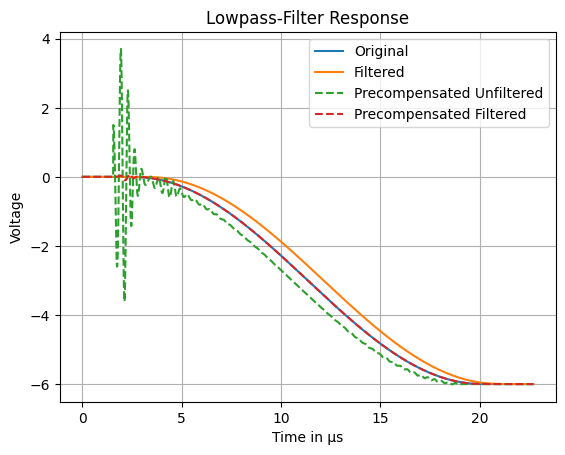

In [1222]:
compression = 1 # manual value
num_samples = 2020 # manual value
CONSTANT_PADDING = 300 # manual value

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array, waveform, compression, num_samples, CONSTANT_PADDING)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)
precompensated = FilterSimulation().trimming(precompensated, CONSTANT_PADDING, first_index, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# Scale to correct values:
time *= 17.5        
original *= -6   
filtered *= -6
precompensated_unfiltered *= -6
precompensated_filtered *= -6

FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)

Lower Bounds of the Simulation (Voltage hits -40 volts)

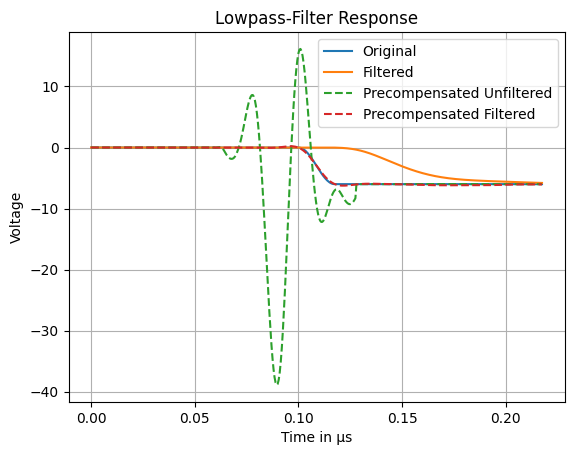

In [1215]:
compression = 1000 # manual value
num_samples = 35000 # manual value
CONSTANT_PADDING = 200 # manual value

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array, waveform, compression, num_samples, CONSTANT_PADDING)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)
precompensated = FilterSimulation().trimming(precompensated, CONSTANT_PADDING, first_index, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# Scale to correct values:
time *= 17.5        
original *= -6   
filtered *= -6
precompensated_unfiltered *= -6
precompensated_filtered *= -6

FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)

Lower Bounds of the Simulation (Voltage hits +40 volts)

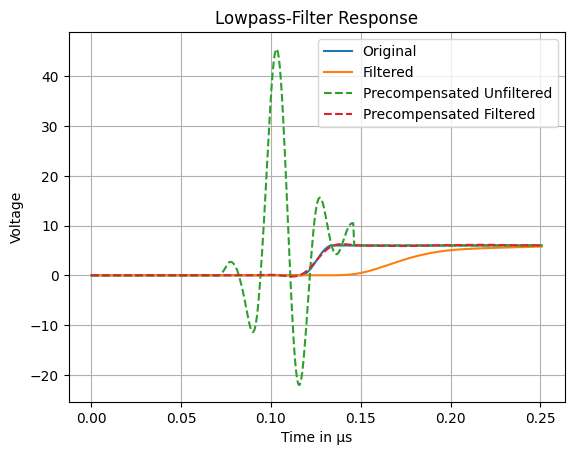

In [1223]:
compression = 1000 # manual value
num_samples = 30000 # manual value
CONSTANT_PADDING = 200 # manual value

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform = np.array([0, -0.0009866358, -0.0039426493, -0.0088563746, -0.0157084194, -0.0244717419, -0.0351117571, -0.0475864738, -0.06184666, -0.0778360372, -0.0954915028, -0.1147433786, -0.1355156863, -0.157726447, -0.1812880051, -0.2061073739, -0.2320866025, -0.2591231629, -0.2871103542, -0.3159377237, -0.3454915028, -0.3756550564, -0.4063093427, -0.4373333832, -0.4686047402, -0.5, -0.5313952598, -0.5626666168, -0.5936906573, -0.6243449436, -0.6545084972, -0.6840622763, -0.7128896458, -0.7408768371, -0.7679133975, -0.7938926261, -0.8187119949, -0.842273553, -0.8644843137, -0.8852566214, -0.9045084972, -0.9221639628, -0.93815334, -0.9524135262, -0.9648882429, -0.9755282581, -0.9842915806, -0.9911436254, -0.9960573507, -0.9990133642, -1])

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array, waveform, compression, num_samples, CONSTANT_PADDING)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)
precompensated = FilterSimulation().trimming(precompensated, CONSTANT_PADDING, first_index, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# Scale to correct values:
time *= 17.5        
original *= -6   
filtered *= -6
precompensated_unfiltered *= -6
precompensated_filtered *= -6

FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)

Multiple Segment Transport Lower Bounds of the Simulation (Voltage hits -40 volts)

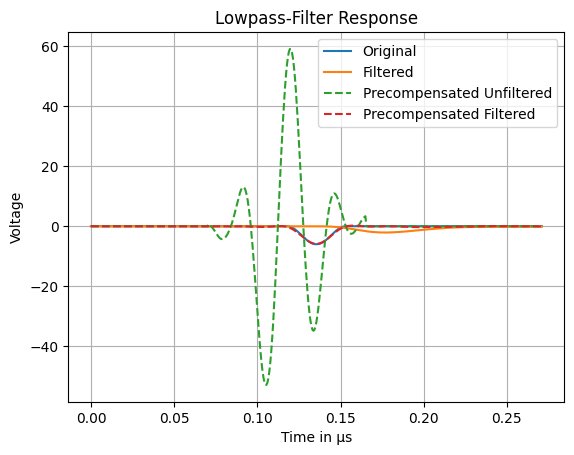

In [1225]:
compression = 1000 # manual value
num_samples = 60000 # manual value
CONSTANT_PADDING = 200 # manual value

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform_1 = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1
waveform_2 = np.array([0, -0.0009866358, -0.0039426493, -0.0088563746, -0.0157084194, -0.0244717419, -0.0351117571, -0.0475864738, -0.06184666, -0.0778360372, -0.0954915028, -0.1147433786, -0.1355156863, -0.157726447, -0.1812880051, -0.2061073739, -0.2320866025, -0.2591231629, -0.2871103542, -0.3159377237, -0.3454915028, -0.3756550564, -0.4063093427, -0.4373333832, -0.4686047402, -0.5, -0.5313952598, -0.5626666168, -0.5936906573, -0.6243449436, -0.6545084972, -0.6840622763, -0.7128896458, -0.7408768371, -0.7679133975, -0.7938926261, -0.8187119949, -0.842273553, -0.8644843137, -0.8852566214, -0.9045084972, -0.9221639628, -0.93815334, -0.9524135262, -0.9648882429, -0.9755282581, -0.9842915806, -0.9911436254, -0.9960573507, -0.9990133642, -1]) + 1

waveform = np.concatenate((waveform_1, waveform_2)) #modify this to concatenate multiple waveforms

new_time_array = time_array + time_array[-1] + time_array[1] - time_array[0]
time_array = np.concatenate((time_array, new_time_array))

original, time, dt, first_index, last_index = FilterSimulation().setup(time_array, waveform, compression, num_samples, CONSTANT_PADDING)

filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * dt
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)
precompensated = FilterSimulation().trimming(precompensated, CONSTANT_PADDING, first_index, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# Scale to correct values:
time *= 17.5        
original *= -6   
filtered *= -6
precompensated_unfiltered *= -6
precompensated_filtered *= -6

original = original[:500]
time = time[:500]
filtered = filtered[:500]
precompensated_unfiltered = precompensated_unfiltered[:500]
precompensated_filtered = precompensated_filtered[:500]

FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)

Testing scaling factors...
Voltage Scale | Time Scale | RMS Error | Max Error | Correlation | SNR (dB)
--------------------------------------------------------------------------------
      0.001 |      0.010 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.016 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.026 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.043 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.070 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.113 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.183 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.298 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.483 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      0.785 |  0.000026 |  0.000361 |    0.995994 |    21.05 | OK
      0.001 |      1.274 |

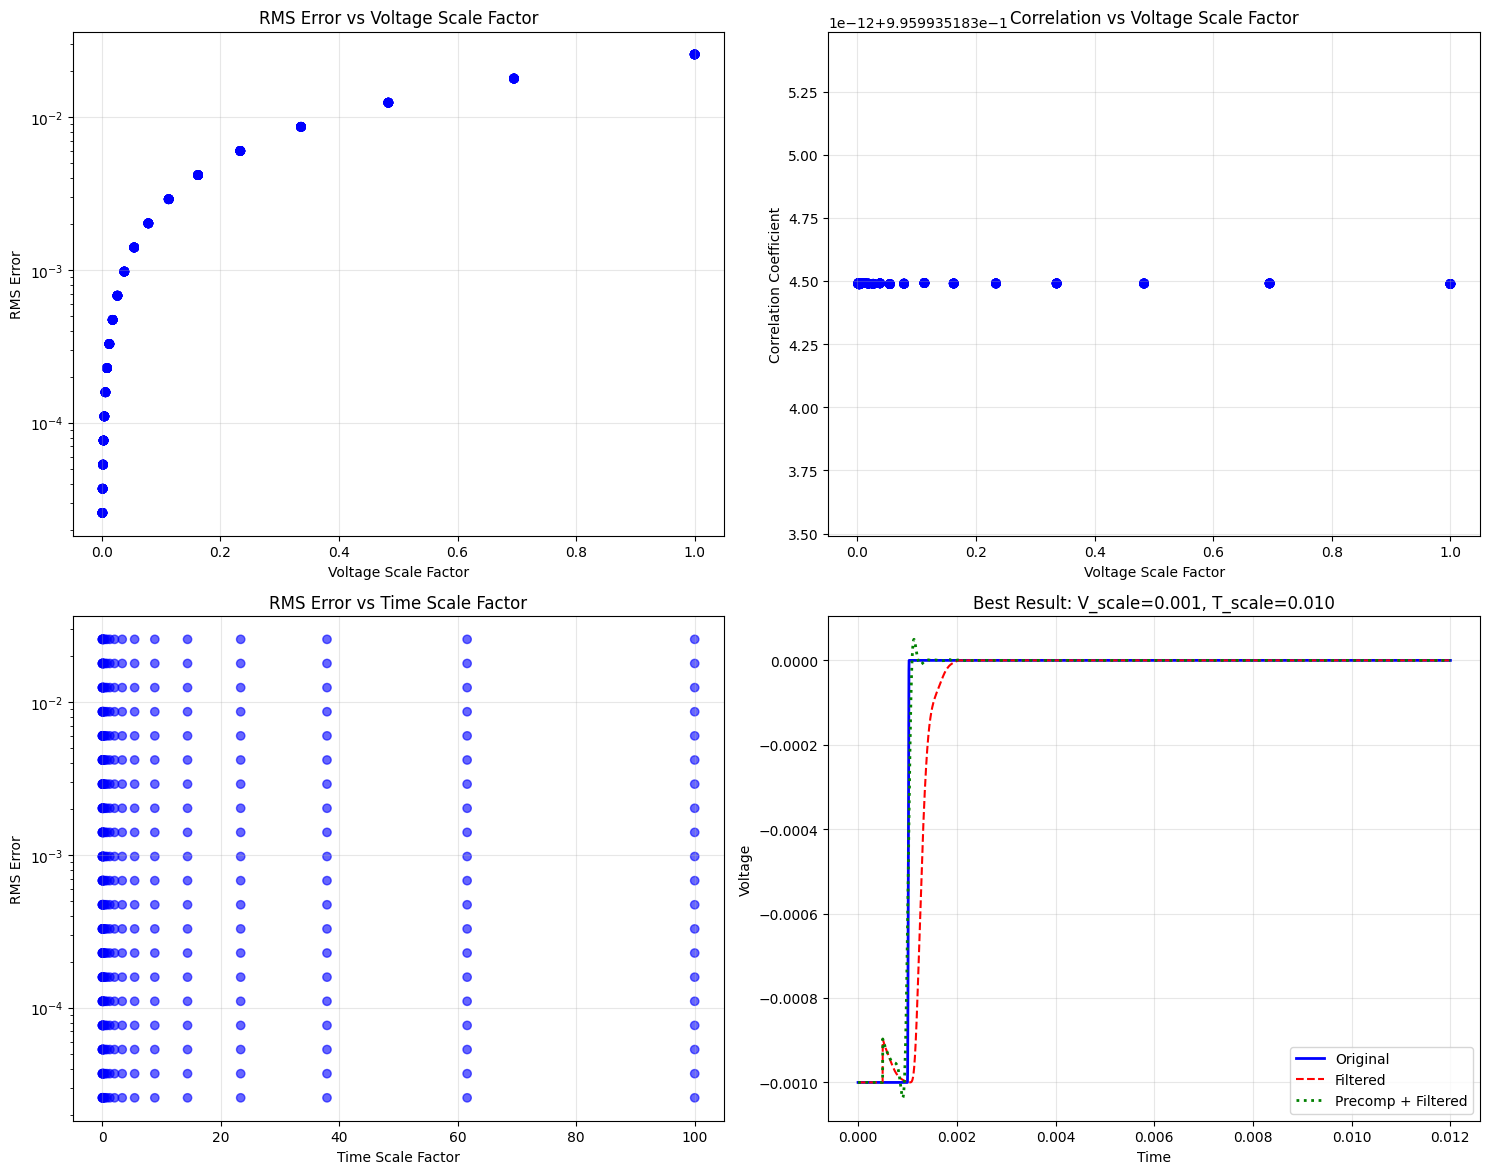

\nMinimum scaling factors:
Voltage scale: 0.001000
Time scale: 0.010000
RMS Error: 0.000026
Correlation: 0.995994


In [ ]:
compression = 300
num_samples = 3000
CONSTANT_PADDING = 300

time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
waveform = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0])

def analyze_scaling_performance(time_scale_factor, voltage_scale_factor, FilterSimulation):
    """
    Analyze precompensation performance for given scaling factors
    Returns metrics to evaluate breakdown
    """
    # Generate dense waveform
    dense_time = np.linspace(0, time_array[-1], num_samples)
    dense_waveform = np.interp(dense_time * compression, time_array, waveform)
    
    time = dense_time
    original = dense_waveform
    original = np.pad(original, pad_width=CONSTANT_PADDING, mode='edge')
    
    dt = time[1] - time[0]
    time = np.arange(len(original)) * dt
    
    first_index = original[0]
    last_index = float(original[-1])
    
    # Apply filtering and precompensation
    filtered = FilterSimulation.convolution(original)
    FilterSimulation.trimming(filtered, CONSTANT_PADDING, first_index)
    shift_f = np.arange(len(filtered)) * dt
    filtered = FilterSimulation.interpolation(time, shift_f, filtered)
    
    precompensated = FilterSimulation.precompensation(original, last_index)
    FilterSimulation.trimming(precompensated, CONSTANT_PADDING, first_index)
    
    precompensated_filtered = FilterSimulation.convolution(precompensated)
    shift_p = np.arange(len(precompensated_filtered)) * dt
    precompensated_filtered = FilterSimulation.interpolation(time, shift_p, precompensated_filtered)
    FilterSimulation.trimming(precompensated_filtered, CONSTANT_PADDING, first_index)
    
    # Apply scaling
    time_scaled = time * time_scale_factor
    original_scaled = original * voltage_scale_factor
    filtered_scaled = filtered * voltage_scale_factor
    precompensated_filtered_scaled = precompensated_filtered * voltage_scale_factor
    
    # Calculate performance metrics
    metrics = calculate_performance_metrics(
        original_scaled, filtered_scaled, precompensated_filtered_scaled, time_scaled
    )
    
    return metrics, (time_scaled, original_scaled, filtered_scaled, precompensated_filtered_scaled)

def calculate_performance_metrics(original, filtered, precompensated_filtered, time):
    """
    Calculate metrics to assess precompensation breakdown
    """
    metrics = {}
    
    # 1. RMS error between precompensated filtered and original
    rms_error = np.sqrt(np.mean((precompensated_filtered - original)**2))
    metrics['rms_error'] = rms_error
    
    # 2. Maximum absolute error
    max_error = np.max(np.abs(precompensated_filtered - original))
    metrics['max_error'] = max_error
    
    # 3. Correlation coefficient
    correlation = np.corrcoef(original, precompensated_filtered)[0, 1]
    metrics['correlation'] = correlation
    
    # 4. Signal-to-noise ratio (in dB)
    signal_power = np.mean(original**2)
    noise_power = np.mean((precompensated_filtered - original)**2)
    snr_db = 10 * np.log10(signal_power / (noise_power + 1e-12))
    metrics['snr_db'] = snr_db
    
    # 5. Peak deviation from expected values
    original_range = np.max(original) - np.min(original)
    error_range = np.max(precompensated_filtered - original) - np.min(precompensated_filtered - original)
    relative_error = error_range / (original_range + 1e-12)
    metrics['relative_error'] = relative_error
    
    # 6. Settling time analysis (time to reach within 5% of final value)
    final_value = original[-1]
    settling_threshold = 0.05 * abs(final_value)
    settling_indices = np.where(np.abs(precompensated_filtered - final_value) <= settling_threshold)[0]
    if len(settling_indices) > 0:
        settling_time = time[settling_indices[0]]
        metrics['settling_time'] = settling_time
    else:
        metrics['settling_time'] = float('inf')
    
    return metrics

def find_minimum_scaling(FilterSimulation, voltage_scale_range, time_scale_range, breakdown_threshold=0.1):
    """
    Systematically test different scaling factors to find minimum before breakdown
    """
    results = []
    
    print("Testing scaling factors...")
    print("Voltage Scale | Time Scale | RMS Error | Max Error | Correlation | SNR (dB)")
    print("-" * 80)
    
    for v_scale in voltage_scale_range:
        for t_scale in time_scale_range:
            try:
                metrics, waveforms = analyze_scaling_performance(t_scale, v_scale, FilterSimulation)
                
                # Check for breakdown conditions
                breakdown = (
                    metrics['rms_error'] > breakdown_threshold or
                    metrics['correlation'] < 0.95 or
                    metrics['snr_db'] < 20 or  # Less than 20 dB SNR indicates poor performance
                    np.isnan(metrics['correlation'])
                )
                
                results.append({
                    'voltage_scale': v_scale,
                    'time_scale': t_scale,
                    'metrics': metrics,
                    'waveforms': waveforms,
                    'breakdown': breakdown
                })
                
                status = "BREAKDOWN" if breakdown else "OK"
                print(f"{v_scale:11.3f} | {t_scale:10.3f} | {metrics['rms_error']:9.6f} | "
                      f"{metrics['max_error']:9.6f} | {metrics['correlation']:11.6f} | "
                      f"{metrics['snr_db']:8.2f} | {status}")
                
            except Exception as e:
                print(f"Error at v_scale={v_scale}, t_scale={t_scale}: {e}")
                continue
    
    return results

def plot_scaling_analysis(results):
    """
    Plot the results of scaling analysis
    """
    # Extract data for plotting
    voltage_scales = [r['voltage_scale'] for r in results]
    time_scales = [r['time_scale'] for r in results]
    rms_errors = [r['metrics']['rms_error'] for r in results]
    correlations = [r['metrics']['correlation'] for r in results]
    breakdowns = [r['breakdown'] for r in results]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: RMS Error vs Voltage Scale
    colors = ['red' if b else 'blue' for b in breakdowns]
    ax1.scatter(voltage_scales, rms_errors, c=colors, alpha=0.6)
    ax1.set_xlabel('Voltage Scale Factor')
    ax1.set_ylabel('RMS Error')
    ax1.set_title('RMS Error vs Voltage Scale Factor')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Correlation vs Voltage Scale  
    ax2.scatter(voltage_scales, correlations, c=colors, alpha=0.6)
    ax2.set_xlabel('Voltage Scale Factor')
    ax2.set_ylabel('Correlation Coefficient')
    ax2.set_title('Correlation vs Voltage Scale Factor')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: RMS Error vs Time Scale
    ax3.scatter(time_scales, rms_errors, c=colors, alpha=0.6)
    ax3.set_xlabel('Time Scale Factor')
    ax3.set_ylabel('RMS Error')
    ax3.set_title('RMS Error vs Time Scale Factor')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Best performing waveforms
    # Find the result with minimum scaling that doesn't break down
    good_results = [r for r in results if not r['breakdown']]
    if good_results:
        best_result = min(good_results, key=lambda x: abs(x['voltage_scale']) + abs(x['time_scale']))
        time, original, filtered, precomp_filtered = best_result['waveforms']
        
        ax4.plot(time, original, 'b-', label='Original', linewidth=2)
        ax4.plot(time, filtered, 'r--', label='Filtered', linewidth=1.5)
        ax4.plot(time, precomp_filtered, 'g:', label='Precomp + Filtered', linewidth=2)
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Voltage')
        ax4.set_title(f'Best Result: V_scale={best_result["voltage_scale"]:.3f}, T_scale={best_result["time_scale"]:.3f}')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage (you'll need to provide your FilterSimulation class):

# Define scaling ranges to test
voltage_scale_range = np.logspace(-3, 0, 20)  # From 0.001 to 1
time_scale_range = np.logspace(-2, 2, 20)     # From 0.01 to 100

# Run the analysis
results = find_minimum_scaling(FilterSimulation(), voltage_scale_range, time_scale_range)

# Plot results
plot_scaling_analysis(results)

# Find the minimum scaling factors that work
good_results = [r for r in results if not r['breakdown']]
if good_results:
    best = min(good_results, key=lambda x: abs(x['voltage_scale']) + abs(x['time_scale']))
    print(f"\\nMinimum scaling factors:")
    print(f"Voltage scale: {best['voltage_scale']:.6f}")
    print(f"Time scale: {best['time_scale']:.6f}")
    print(f"RMS Error: {best['metrics']['rms_error']:.6f}")
    print(f"Correlation: {best['metrics']['correlation']:.6f}")

